In [1]:
from pathlib import Path
import numpy as np
import os
import datetime
import veloxchem as vlx
import networkx as nx
import matplotlib.pyplot as plt



In [2]:
from itertools import permutations
def bohr_in_angstrom(bohr):
    """
    Convert a distance from Bohr units to Angstroms.

    Parameters:
    bohr (float): Distance in Bohr units.

    Returns:
    float: Distance in Angstroms.
    """
    # Conversion factor from Bohr to Angstrom
    bohr_to_angstrom = 0.529177
    return bohr * bohr_to_angstrom

def _Molecule_moments_of_inertia(molecule):
    """
    Calculates the moment of inertia tensor and principle axes.

    :return:
        The principle moments of inertia.
    """

    masses = molecule.masses_to_numpy()
    coordinates = molecule.get_coordinates_in_bohr()
    center_of_mass = np.array(molecule.center_of_mass_in_bohr())
    natm = molecule.number_of_atoms()

    # Coordinates in the center-of-mass frame
    coords_com = coordinates - center_of_mass[np.newaxis, :]

    # Moment of inertia tensor
    Imat_atoms = [
        masses[i] * (np.eye(3) * (np.dot(coords_com[i], coords_com[i])) -
                     np.outer(coords_com[i], coords_com[i]))
        for i in range(natm)
    ]
    Imom = np.sum(Imat_atoms, axis=0)

    # Principal moments
    Ivals, Ivecs = np.linalg.eigh(Imom)
    # Eigenvectors are in the rows after transpose
    Ivecs = Ivecs.T

    return Ivals, Ivecs

class SymmetryAnalyzer:
    """
    A class to determine the point group of nearly symmetric molecules within selected
    tolerance tresholds (in Schoenflies convention) and then to symmetrize it perfectly
    in the detected point group or in one od its subgroups.

    1. The coordinates are reexpressed in the center of mass frame.
    2. The principal axis and moment are obtained by computing the eigenvalues and 
       eigenvectors of the inertia tensor.
        - Linear molecule have one vanishing eigenvalue.
        - Asymmetric top molecules have non-degenerated eigenvalues.
        - Symmetric molecules have doubly degenerated eigenvalues.
        - Spherical molecules have triply degenerated eigenvalues.
    3. Each category is then treated following a typical detection tree.

    The available tolerance parameters are: loose, tight, very tight.

    Instance variables
        - schoenflies_symbol: the pointgroup schoenflies symbol.
        - max_order: the maximum proper rotational axis order. 
        - inequivalent_atoms: a dictionary containing the operations names and the associated inequivalent atoms.
        - primary_axis: axis defined as z cartesian axis for reorientation in point group convention.
        - secondary_axis: axis perpendicular to primary axis to build conventional cartesian frame for reorientation.
        - molecule_type: the type of molecule on a detection tree (e.g., linear, cyclic, etc.).
    """

    def __init__(self): 
        """
        Initializes the SymmetryAnalyzer instances.
        """

        # Initializes variables
        self._schoenflies_symbol = ''
        self._max_order = 1
        self._inequivalent_atoms = {}
        self._primary_axis = [1., 0., 0.]
        self._secondary_axis = [0., 1., 0.]
        self._molecule_type = ''
        
    def identify_pointgroup(self,
                            molecule,
                            tolerance = 'tight',user_tolerance_eig=0,user_tolerance_ang=0):
        """
        Analyze the symmetry of a given molecule based on its nuclear framework.

        :param molecule:
            A VeloxChem molecule object.

        :param tolerance:
            A tolerance threshold string available in tolerance_keywords.
            Default: tight

        :return:
            A dictionary containing:
                - The pointgroup symbol.
                - (The list of detected elements in spectific cases.)
                - The list of all expected elements.
                - The list of available Abelian groups for symmetrization.
                - An array with the reoriented geometry in bohr.
        """

        # Define the tolerance parameters
        tolerance = tolerance.lower()

        if tolerance == 'loose':
            self._tolerance_eig = 0.8
            self._tolerance_ang = 0.085
        elif tolerance == 'tight':
            self._tolerance_eig = 0.4
            self._tolerance_ang = 0.070    # about 4 degrees   
        elif tolerance == 'very tight':
            self._tolerance_eig = 0.002
            self._tolerance_ang = 0.035     # about 2 degrees
        elif tolerance == 'user':
            self._tolerance_eig = user_tolerance_eig
            self._tolerance_ang = user_tolerance_ang

        else:
            raise KeyError("Tolerance criterion not available.")

        # Read and express geometry in center of mass (COM) frame
        # Geom and COM in bohr because moments of inertia are defined in bohr in Molecule module
        coordinates = molecule.get_coordinates_in_bohr()
        self._symbols = molecule.get_labels()
        self._natoms = len(self._symbols)
        center_of_mass = molecule.center_of_mass_in_bohr()
        self._cent_coord = coordinates - center_of_mass

        # Get the principal momemts amd axes of inertia
        Ivals, Ivecs =_Molecule_moments_of_inertia(molecule)
        self._Ivals = Ivals
        self._Ivecs = Ivecs

        # Initializes ensembles of results
        symmetry_analysis = {}

        # Handle case of isolated atom
        if self._natoms == 1:
            self._schoenflies_symbol = "O(3)"
            self._molecule_type = "isolated_atom"
            symmetry_analysis["degeneracy"] = "Input structure is an isolated atom."

        else:
            # Get the degeneracy of the eigenvalues of the inertia tensor
            eig_degeneracy = get_degeneracy(self._Ivals, self._tolerance_eig)

            # Linear groups
            if np.min(abs(self._Ivals)) < self._tolerance_eig:
                self._linear()
                symmetry_analysis["degeneracy"] = "Molecule is linear."

            # Asymmetric group
            elif eig_degeneracy == 1:
                self._asymmetric()
                symmetry_analysis["degeneracy"] = "Principal moments of inertia are not degenerated."

            # Symmetric group
            elif eig_degeneracy == 2:
                self._symmetric()
                symmetry_analysis["degeneracy"] = "Principal moments of inertia are doubly degenerated."

            # Spherical group
            elif eig_degeneracy == 3:
                self._spherical()
                symmetry_analysis["degeneracy"] = "Principal moments of inertia are triply degenerated."

        # Collect the results
        symmetry_analysis["Point_group"] = self._schoenflies_symbol

        if self._schoenflies_symbol in all_symmetry_elements:
            symmetry_elements_list = all_symmetry_elements[self._schoenflies_symbol]
            symmetry_analysis["Expected_elements"] = symmetry_elements_list

        if self._schoenflies_symbol in groups_for_symmetrization:
            Groups_for_symm_list = groups_for_symmetrization[self._schoenflies_symbol]
            symmetry_analysis["Groups_for_symm"] = Groups_for_symm_list

        return symmetry_analysis
    
    def print_symmetry_results(self, results_dict, symmetry_info = True):
        """
        Build a small output with the results of the symmetry analysis.

        :param results_dict:
            The dictionary containing the different results from the pointgroup_identify function.
        
        :return:
            The results in a visual friendly output.
        """
        
        if symmetry_info:
            print(results_dict["degeneracy"],"\n")
            
            print("Point group: {}\n".format(results_dict["Point_group"]))

            if "Expected_elements" in results_dict:
                print("All expected symmetry elements: {}".format(results_dict["Expected_elements"]))

            if "Groups_for_symm" in results_dict:
                print("Available Abelian groups for symmetrization: {}".format(results_dict["Groups_for_symm"]))
            else:
                print("No available Abelian groups for symmetrization.")
        
        else:
           print("Point group: {}".format(results_dict["Point_group"])) 

    def print_tolerance_keywords(self):
        """
        :return:
            The available tolerance keywords.
        """

        tolerance_keywords = ["loose", "tight", "very tight"]

        return tolerance_keywords

    def symmetrize_pointgroup(self, symmetry_data, pointgoup_to_symmetrize="C1"):
        """
        Symmetrize in chosen available Abelian group with real representation
        and reorient molecules. Only reorient if more than 100 atoms.

        :param symmetry_data:
            The dictionary containing the different results from the pointgroup_symmetrize function.

        :param pointgoup_to_symmetrize:
            The chosen point group in which the molecule will be symmetrized. 
            Default: C1.

        :return:
            The symmetrized molecule as a string.
        """
       
        # Initializes variables
        self._symbols_atom_sym = []

        # Temporary
        symmetrized_data = {}

        def _reorient_molecule(coords):
            """
            Store the geometry reoriented in the conventional point group orientation
            and attibute associated list of atomic labels. 
            The spherical molecules are reoriented with their principal axis as z cartesian axis.

            :param coords:
                The coordinates to reorient.
            """

            if self._molecule_type == "spherical":    
                reoriented_coords = self._conventional_orientation(self._main_axis, self._p_axis, coords)
            else:
                reoriented_coords = self._conventional_orientation(self._primary_axis, self._secondary_axis, coords)

            #symmetrized_coords_in_angstrom = reoriented_coords * bohr_in_angstrom()
            symmetrized_coords_in_angstrom =  bohr_in_angstrom(reoriented_coords)
            self._symbols_atom_sym = self._symbols

            return symmetrized_coords_in_angstrom
        
        # Handle C1 and O(3) groups
        if pointgoup_to_symmetrize in ["C1", "O(3)"]:
            symmetrized_coords_in_angstrom = _reorient_molecule(self._cent_coord)

        # Check that the chosen point group is available for symmetrization
        elif pointgoup_to_symmetrize not in symmetry_data["Groups_for_symm"] or self._natoms > 100:
            raise KeyError("Point group not available for symmetrization.")
        
        # Symmetrize molecules and reorient
        # The spherical molecules are reorient with C2 axis along z cartesian axis (D2x orientation)
        else:
            symmetrized_coords = self._symmetrize_molecule(pointgoup_to_symmetrize)
            reoriented_coords = self._conventional_orientation(self._primary_axis, self._secondary_axis, symmetrized_coords)
            symmetrized_coords_in_angstrom = reoriented_coords * bohr_in_angstrom()

        # Temporary
        symmetrized_data["inequiv_atoms_by_op"] = self._inequivalent_atoms

        new_molecule_string = f'{self._natoms}\n\n'

        for a in range(self._natoms):
            xa, ya, za = symmetrized_coords_in_angstrom[a]
            new_molecule_string += f'{self._symbols_atom_sym[a]:<6s} {xa:22.8f} {ya:22.8f} {za:22.8f}\n'

        return new_molecule_string

    def _linear(self):
        """
        Handle linear molecules.

        :return:
            The Schoenflies symbol, list of detected elements, and reoriented coordinates.
        """

        # Set type of molecule for reorientation
        self._molecule_type = "linear"

        idx = np.argmin(self._Ivals)
        principal_axis = self._Ivecs[idx]
        p_axis = get_perpendicular(principal_axis)

        # Detect C2 axis along principal axis (for symmetrization)
        self._check_op(Rotation(principal_axis, order=2), "C2")

        # Detect sigma plane along principal axis (for symmetrization)
        self._check_op(Reflection(p_axis), "sigma_v")

        # Check for inversion center at center of mass
        if self._check_op(Inversion(), "i"):
            self._schoenflies_symbol = 'Dinfh'

            # Detect sigma plane and C2 axis perpendicular to principal axis (for symmetrization)
            self._check_op(Rotation(p_axis, order=2), "C2")
            self._check_op(Reflection(principal_axis), "sigma_h")

        else:
            self._schoenflies_symbol = 'Cinfv'
        
        # Set orientation
        self._set_orientation(principal_axis, p_axis)

        # Set primary axis as z cartesian axis for conventional reorientation
        self._primary_axis = [0.,0.,1.]

    def _asymmetric(self):
        """
        Handle asymmetric top molecules.
        """

        # Set orientation
        self._set_orientation(self._Ivecs[0], self._Ivecs[1])

        # Check for any C2 axis
        n_axis_c2 = 0
        principal_axis = [1, 0, 0]
        for axis in np.identity(3):
            c2 = Rotation(axis, order=2)
            if self._check_op(c2, "C2"):
                n_axis_c2 += 1
                principal_axis = axis
                break

        p_axis = get_perpendicular(principal_axis)
        if self._check_op(Rotation(p_axis, order=2), "C2_p"):
            n_axis_c2 += 1
            self._secondary_axis = p_axis

        self._max_order = 2

        if n_axis_c2 == 0:
            self._max_order = 0
            self._no_rot_axis()
        elif n_axis_c2 == 1:
            self._cyclic(principal_axis)
        else:
            self._dihedral(principal_axis)

    def _symmetric(self):
            """
            Handle symmetric molecules.
            """

            # Get the only non-degenareted principal moment fo inertia and set the principal axis
            # along the associated eigenvector
            idx = get_non_degenerated(self._Ivals, self._tolerance_eig)
            principal_axis = self._Ivecs[idx]

            # Determine the highest possible rotation axis order along the principal axis
            self._max_order = self._get_axis_rot_order(principal_axis, n_max=9)

            # Check for C2 axis along principal axis
            # Imperative for symmetrization in abelian with real characters subgroups
            self._check_op(Rotation(principal_axis, order=2), "C2")

            # Get the perpendicualar axis to principal axis and check for C2 rotation axis 
            # along p_axis by rotating p_axis along the principal axis
            p_axis = get_perpendicular(principal_axis)
            for angle in np.arange(0, np.pi, 0.1* np.pi / self._max_order):
                axis = np.dot(p_axis, rotation_matrix(principal_axis, angle))
                c2 = Rotation(axis, order=2)
                if self._check_op(c2, "C2_p"):
                    self._dihedral(principal_axis)
                    return
                        
            self._cyclic(principal_axis)

    def _spherical(self):
        """
        Handle spherical groups (I, O, T) in iterative way by increasing tolerance if no axis is found.
        """

        # Set type of molecule for reorientation
        self._molecule_type = "spherical"
        # Set additional axis for reorientation in D2x group
        self._main_axis = [1., 0., 0.]
        self._p_axis = [0., 1., 0.]

        principal_axis = None
        while principal_axis is None:
            for axis in get_cubed_sphere_grid_points(self._tolerance_ang):
                c5 = Rotation(axis, order=5)
                c4 = Rotation(axis, order=4)
                c3 = Rotation(axis, order=3)

                # Check for C5 axis
                if self._check_op(c5, "C5"):
                    self._schoenflies_symbol = "I"
                    principal_axis = axis
                    self._max_order = 5
                    break
                # Check for C4 axis
                elif self._check_op(c4, "C4"):
                    self._schoenflies_symbol = "O"
                    principal_axis = axis
                    self._max_order = 4
                    break
                # Check for C3 axis
                elif self._check_op(c3, "C3"):
                    self._schoenflies_symbol = "T"
                    principal_axis = axis
                    self._max_order = 3
        
        # Increase angular tolerance
        if principal_axis is None:
            self._tolerance_ang *= 1.1

        p_axis_base = get_perpendicular(principal_axis)

        # I or Ih
        if self._schoenflies_symbol == 'I':

            def _determine_orientation_I(principal_axis):
                """
                Determine the orientation of the molecule within the icosahedral symmetry group.
                The angle is derived from geometric considerations to align the orientation
                axis with the symmetry axis.

                :param principal_axis:
                    The principal axis obtained with _set_orientation. 

                :return:
                    The current orientation in the reference frame.
                """
                
                r_matrix = rotation_matrix(p_axis_base, np.arcsin((np.sqrt(5)+1)/(2*np.sqrt(3))))
                axis = np.dot(principal_axis, r_matrix.T)

                # set molecule orientation in I
                for angle in np.arange(0, 2*np.pi+self._tolerance_ang, self._tolerance_ang):
                    rot_matrix = rotation_matrix(principal_axis, angle)

                    c5_axis = np.dot(axis, rot_matrix.T)
                    c5 = Rotation(c5_axis, order=5)

                    if self._check_op(c5, "C5"):
                        t_axis = np.dot(principal_axis, rotation_matrix(p_axis_base, np.pi/2).T)
                        return np.dot(t_axis, rot_matrix.T)

            # Set orientation
            p_axis = _determine_orientation_I(principal_axis)
            self._main_axis = principal_axis
            self._p_axis = p_axis

            # Check for inverison center at center of mass
            if self._check_op(Inversion(), "i"):
                self._schoenflies_symbol += 'h'

            # Check for any C2 axis (for reorientation)
            for another_axis in get_cubed_sphere_grid_points(self._tolerance_ang):
                c2 = Rotation(another_axis, order=2)
                if self._check_op(c2, "C2"):
                    self._primary_axis = another_axis

                    # Check for one reflexion plane (for symmetrization)
                    self._check_op(Reflection(another_axis), "sigma_h")
                    break

            # Check for a C2 axis perpendicular to the first one (for reorientation)
            C2_p_axis = get_perpendicular(another_axis)
            for angle in np.arange(0, np.pi + self._tolerance_ang, 0.1*np.pi / 2):
                h_axis = np.dot(C2_p_axis, rotation_matrix(another_axis, angle))
                if self._check_op(Rotation(h_axis), "C2_p"):
                    self._secondary_axis = h_axis
                    break

        # O or Oh
        if self._schoenflies_symbol == 'O':
            
            def _determine_orientation_O(principal_axis):
                """
                Determine the orientation of the molecule within the octahedron symmetry group. 

                :param principal_axis:
                    The principal axis obtained with _set_orientation. 

                :return:
                    The current orientation in the reference frame.
                """

                r_matrix = rotation_matrix(p_axis_base, np.pi/2)
                axis = np.dot(principal_axis, r_matrix.T)

                for angle in np.arange(0, 2*np.pi / self._max_order+self._tolerance_ang, self._tolerance_ang):
                    rot_matrix = rotation_matrix(principal_axis, angle)

                    c4_axis = np.dot(axis, rot_matrix.T)
                    c4 = Rotation(c4_axis, order=4)

                    if self._check_op(c4, "C4"):
                        return axis

            # Set orientation
            p_axis = _determine_orientation_O(principal_axis)
            self._set_orientation(principal_axis, p_axis)

            # Check for inverison center at center of mass
            if self._check_op(Inversion(), "i"):
                self._schoenflies_symbol += 'h'

            # Check for any C2 axis (for reorientation)
            if self._check_op(Rotation(self._main_axis, order=2), "C2"):

                # Check for one reflexion plane (for symmetrization)
                self._check_op(Reflection(self._main_axis), "sigma_h")

            # Check for a C2 axis perpendicular to the first one (for reorientation)
            C2_p_axis = get_perpendicular(principal_axis)
            for angle in np.arange(0, np.pi + self._tolerance_ang, 0.1*np.pi / 2):
                h_axis = np.dot(C2_p_axis, rotation_matrix(principal_axis, angle))
                if self._check_op(Rotation(h_axis), "C2_p"):
                    break

        # T or Td, Th
        if self._schoenflies_symbol == 'T':

            def _determine_orientation_T(principal_axis):
                """
                Determine the orientation of the molecule within the tetrahedron symmetry group. 

                :param principal_axis:
                    The principal axis obtained with _set_orientation. 

                :return:
                    The current orientation in the reference frame.
                """

                r_matrix = rotation_matrix(p_axis_base, -np.arccos(-1/3))
                axis = np.dot(principal_axis, r_matrix.T)

                for angle in np.arange(0, 2*np.pi / self._max_order + self._tolerance_ang, self._tolerance_ang):
                    rot_matrix = rotation_matrix(principal_axis, angle)

                    c3_axis = np.dot(axis, rot_matrix.T)
                    c3 = Rotation(c3_axis, order=3)

                    if self._check_op(c3, "C3"):
                        t_axis = np.dot(principal_axis, rotation_matrix(p_axis_base, np.pi/2).T)
                        return np.dot(t_axis, rot_matrix.T)

            p_axis = _determine_orientation_T(principal_axis)
            self._main_axis = principal_axis
            self._p_axis = p_axis

            # Check for any C2 axis (for reorientation)
            for another_axis in get_cubed_sphere_grid_points(self._tolerance_ang):
                c2 = Rotation(another_axis, order=2)
                if self._check_op(c2, "C2"):
                    self._primary_axis = another_axis
                    break
                    
            # Check for a C2 axis perpendicular to the first one (for reorientation)
            C2_p_axis = get_perpendicular(principal_axis)
            for angle in np.arange(0, np.pi + self._tolerance_ang, 0.1*np.pi / 2):
                h_axis = np.dot(C2_p_axis, rotation_matrix(principal_axis, angle))
                if self._check_op(Rotation(h_axis), "C2_p"):
                    self._p_axis = h_axis
                    break

            # Check for inverison center at center of mass
            if self._check_op(Inversion(), "i"):
                self._schoenflies_symbol += 'h'
                return

            # Check for any reflexion plane 
            if self._check_op(Reflection(self._p_axis), "sigma_v"):
                self._schoenflies_symbol += 'd'
                return

    def _no_rot_axis(self):
        """
        Detect point group of molecule with no rotation axis.

        :return:
            The Schoenflies symbol and list of detected elements.
        """

        # Set type of molecule for reorientation
        self._molecule_type = "asym_top"

        for i, vector in enumerate(np.identity(3)):
            if self._check_op(Reflection(vector), "sigma"):
                self._schoenflies_symbol = 'Cs'
                self._primary_axis = vector
                self._secondary_axis = get_perpendicular(vector)
                self._set_orientation(vector, self._secondary_axis)
                break
            else:
                if self._check_op(Inversion(), "i"):
                    self._schoenflies_symbol = 'Ci'
                    break
                else:
                    self._schoenflies_symbol = 'C1'

    def _cyclic(self, principal_axis):
        """
        Detect point group of cylic group molecules.

        :param principal_axis:
            The principal axis obtained with _set_orientation.

        :return:
            The Schoenflies symbol and list of detected elements.
        """

        # Set type of molecule for reorientation
        self._molecule_type = "cyclic"
        self._primary_axis = principal_axis

        self._schoenflies_symbol = "C{}".format(self._max_order)
        
        # Check for reflexion planes perpenducular to the principal axis
        h_symbols = False
        if self._check_op(Reflection(principal_axis), "sigma_h"):
            self._schoenflies_symbol += 'h'
            h_symbols = True

        p_axis = get_perpendicular(principal_axis)
        self._secondary_axis = p_axis

        # Check for reflexion planes containing the principal axis
        v_symbol = set()
        for angle in np.arange(0, np.pi, 0.1*np.pi / self._max_order + self._tolerance_ang):
            axis = np.dot(p_axis, rotation_matrix(principal_axis, angle))
            if self._check_op(Reflection(axis), "sigma_v") and not h_symbols:
                v_symbol.add('v')

        self._schoenflies_symbol += ''.join(v_symbol)

        # Check for inversion center at center of mass
        self._check_op(Inversion(), "i")

        # Check for improper rotational axis along the principal axis.
        if self._check_op(ImproperRotation(principal_axis, order=2*self._max_order), "S{}".format(2 * self._max_order)):
            self._schoenflies_symbol = "S{}".format(2 * self._max_order)
            
    def _dihedral(self, principal_axis):
        """
        Detect point group of dihedral group molecules.

        :param principal_axis:
            The principal axis obtained with _set_orientation.

        :return:
            The Schoenflies symbol and list of detected elements.
        """

        # Set type of molecule for reorientation
        self._molecule_type = "cyclic"
        self._primary_axis = principal_axis

        # Determine perpendicular axis to principal axis
        p_axis = get_perpendicular(principal_axis)

        if self._max_order == 1:
            # D1 is equivalent to C2
            self._schoenflies_symbol = "C2"
        else:
            self._schoenflies_symbol = "D{}".format(self._max_order)

        # Check for inversion center at center of mass
        self._check_op(Inversion(), "i")

        # Check for reflexion planes perpenducular to the principal axis
        h_symbols = False
        if self._check_op(Reflection(principal_axis), "sigma_h") and not h_symbols:
            self._schoenflies_symbol += 'h'
            h_symbols = True
        
        # Check for reflexion planes containing the principal axis
        d_symbol = False
        for angle in np.arange(0, np.pi, 0.5*np.pi / self._max_order):
            axis = np.dot(p_axis, rotation_matrix(principal_axis, angle))
            if self._check_op(Reflection(axis), "sigma_v") and not h_symbols and not d_symbol:
                self._schoenflies_symbol += 'd'
                d_symbol = True
    
    def _get_axis_rot_order(self, axis, n_max):
            """
            Get rotation order for a given axis.

            :param axis:
                The axis.

            :param n_max:
                Maximum order to scan.

            :return:
                The order.
            """

            def max_rotation_order(tolerance):
                """
                Set the range of maximum order possible.

                :param tolerance:
                    The tolerance parameter.
                """

                for i in range(2, 15):
                    if 2*np.pi / (i * (i - 1)) <= tolerance:
                        return i-1

            n_max = np.min([max_rotation_order(self._tolerance_ang), n_max])

            for i in range(n_max, 1, -1):
                Cn = Rotation(axis, order=i)
                if self._check_op(Cn, "C{}".format(i)):
                    return i
            return 1

    def _check_op(self, operation, element_string, tol_factor=1.0):
        """
        Check if the given symmetry operation exists in the point group of the molecule.

        :param operation:
            The matrix representative of the symmetry operation.

        :param tol_factor:
            A factor to scale the tolerance value.

        :return:
            True if the symmetry operation exists in the point group, False otherwise.
        """

        # Get representative of the operation
        sym_matrix = operation.get_matrix()

        # Define absolte tolerance from the eigenvalue tolerance
        error_abs_rad = abs_to_rad(self._tolerance_eig, coord=self._cent_coord)

        # Get COM frame coordinates after the operation
        op_coordinates = np.matmul(self._cent_coord, sym_matrix)

        # Initialize objects to obtain inequivalent atoms
        mapping = []
        inequivalent_atoms_by_operation = set()

        # Check if operation exists
        for idx, op_coord in enumerate(op_coordinates):
            # Calculate the differences in radii and angles
            difference_rad = radius_diff_in_radiants(op_coord, self._cent_coord, self._tolerance_eig)
            difference_ang = angle_between_vector_matrix(op_coord, self._cent_coord, self._tolerance_eig)

            def check_diff(diff, diff2):
                for idx_2, (d1, d2) in enumerate(zip(diff, diff2)):
                    if self._symbols[idx_2] != self._symbols[idx]:
                        continue
                    tolerance_total = self._tolerance_ang * tol_factor + error_abs_rad[idx_2]
                    if d1 < tolerance_total and d2 < tolerance_total:
                        return True
                return False

            if not check_diff(difference_ang, difference_rad):
                return False
            
            # Save the original atom index, the manipulated atom index, and their associated original coordinates
            manipulated_atom_idx = np.argmin(np.linalg.norm(self._cent_coord - op_coord, axis=1))
            mapping.append((idx, manipulated_atom_idx))

            # Check if the original atom is already in the list of inequivalent atoms
            if idx == manipulated_atom_idx:
                inequivalent_atoms_by_operation.add(idx)
            elif idx != manipulated_atom_idx:
                for mapping_tuple in mapping:
                    if mapping_tuple[0] not in [indice_tuple[1] for indice_tuple in mapping]:
                        inequivalent_atoms_by_operation.add(mapping_tuple[0])

        # Save string and inequivalent atom indices for detected operations used in symmetrization
        if element_string in ["C2", "C2_p", "sigma", "sigma_h", "sigma_v", "sigma", "i"]:
            self._inequivalent_atoms[element_string] = inequivalent_atoms_by_operation

        return True

    def _symmetrize_molecule(self, pointgroup):
        """
        Symmetrize a molecule based on the inequivalent atoms for each orperation.
        If atoms are found at the same position within a tolerance after applying all operation, 
        the average position is calculated and saved.

        :param pointgroup:
            The chosen point group for symmetrization.

        :return:
            A array with the coordinates of the symmetrized molecule.
        """

        # Initialize the list of coordinates for the inequivalent atoms after symmetrization
        full_symmetrized_coord = []
        full_symmetrized_symbols = []
        
        # Define the possible symmetry operation to apply on the inequivalent coordinates
        symmetry_operation = {
            "i" : Inversion(),
            "C2" : Rotation(self._primary_axis, order=2),
            "C2_p" : Rotation(self._secondary_axis, order=2),
            "sigma_h" : Reflection(self._primary_axis),
            "sigma_v" : Reflection(self._secondary_axis)
        }

        # Loop over the operations to apply and generate the representatives
        # In reverse order to apply rotation in last as it is the main operator 
        for operation in reversed(generators[pointgroup]):
            if operation in self._inequivalent_atoms:
                representative = symmetry_operation[operation]
                sym_matrix = representative.get_matrix()

                # Retrieve the coordinates for the current set of inequivalent atoms
                ineq_coords = [self._cent_coord[index] for index in self._inequivalent_atoms[operation]]
                ineq_symbols = [self._symbols[index] for index in self._inequivalent_atoms[operation]]

                # Apply the symmetry operation to the coordinates of the inequivalent atoms
                op_coordinates = np.dot(ineq_coords, sym_matrix.T)

        # Loop over each pair of arrays of coordinates and
        # calculate the absolute difference between the original and generated coordinates
        for i, (coord, symbol) in enumerate(zip(ineq_coords, ineq_symbols)):
                abs_diff = np.abs(coord - op_coordinates[i])

                # If the absolute difference is greater than a small tolerance value, 
                # append both coordinates and symbols to the respective lists
                if np.any(abs_diff > 1.0):
                    full_symmetrized_coord.append(coord)
                    full_symmetrized_coord.append(op_coordinates[i])
                    full_symmetrized_symbols.append(symbol)
                    full_symmetrized_symbols.append(symbol)  # Symbol is the same for both coordinates
                # If the absolute difference is within the tolerance value, 
                # append the symmetrized coordinate and symbol to the respective lists
                else:
                    average_pos = (coord + op_coordinates[i])/2
                    full_symmetrized_coord.append(average_pos)
                    full_symmetrized_symbols.append(symbol)

        # Check that the number of generated atoms is the same as the original molecule
        assert self._natoms == len(full_symmetrized_coord), "Number of generated atoms does not match initial molecule."

        # Store the symbols of the inequivalent atoms in the instance variable
        self._symbols_atom_sym = full_symmetrized_symbols

        return np.array(full_symmetrized_coord)

    def _set_orientation(self, principal_axis, p_axis):
        """
        Set molecular orientation along principal_axis (x) and p_axis (y).

        :param principal_axis:
            Principal orientation axis (must be unitary).

        :param p_axis:
            Secondary axis perpendicular to principal (must be unitary).
        """

        assert np.linalg.norm(principal_axis) > 1e-1, "Principal axis is not unitary."
        assert np.linalg.norm(p_axis) > 1e-1, "p_axis is not unitary."

        orientation = np.array([principal_axis, p_axis, np.cross(principal_axis, p_axis)])
        self._cent_coord = np.dot(self._cent_coord, orientation.T)
    
    def _conventional_orientation(self, main_axis, p_axis, coords):
        """
        Set molecular orientation in point group convention:
            - a right-handed cartesian,
            - origin at center of mass,
            - highest rotational axis asz cartesian axis,
            - if z in along a sigma plane, x is chosen as perpendicular to the plane,
            - if z is perpendicular to a sigma plane, x and y are in the plane,
            - if no rotational axis but a sigma plane, z is set along the plane,
            - if no rotational axis nor sigma plane, x and y are defined along the two principal inertia axes
              associated with the two smallest principal moments.

        :param main_axis:
            The axis to align with the z cartesian axis.

        :param p_axis:
            A axis perpendicular to main_axis to align with the x cartesian axis.

        :param coords:
            The coordinates to reorient.
            
        :return:
            A list of arrays with the cartesian coordinates.
        """
        
        if self._molecule_type =="isolated_atom":
            return
        elif self._molecule_type == "linear":
            orientation = np.array([[0.,0.,1.], [0.,1.,0.], [1.,0.,0.]])
            reoriented_coordinates = np.dot(coords, orientation.T)
        elif self._molecule_type == "asym_top":
            reoriented_coordinates = coords
        else:
            orientation = np.array([p_axis, np.cross(main_axis, p_axis), main_axis])
            reoriented_coordinates = np.dot(coords, orientation.T)

        return reoriented_coordinates



"""
The following classes determine the representatives of the symmetry operations.
"""
class Inversion:
    def get_matrix(self):

        return -np.identity(3)
    
class Rotation:
    def __init__(self, axis, order=1):

        self._order = order
        self._axis = np.array(axis)

    def get_matrix(self):

        return rotation_matrix(self._axis, 2*np.pi / self._order)
    
class Reflection:
    def __init__(self, axis):

        norm = np.linalg.norm(axis)
        assert abs(norm) > 1e-8
        self._axis = np.array(axis) / norm   # normalize axis

    def get_matrix(self):

        return np.identity(3) - 2*np.outer(self._axis, self._axis)
    
class ImproperRotation:
    def __init__(self, axis, order=1):

        self._order = order
        self._axis = np.array(axis)

    def get_matrix(self):
        
        # Build  the rotation matrix
        rot_matrix = rotation_matrix(self._axis, 2*np.pi / self._order)

        # Build the reflexion matrix
        reflection = Reflection(self._axis)
        refl_matrix = reflection.get_matrix()

        return np.dot(rot_matrix, refl_matrix.T)



def get_degeneracy(Ivals, tolerance):
        """
        Get the degeneracy of the principal inertia moments.

        :param Ivals:
            The array of eigenvalues.

        :param tolerance:
            The tolerance parameter on the eigenvalues.

        :return:
            The degree of degeneracy.
        """

        for ev1 in Ivals:
            single_deg = 0
            for ev2 in Ivals:
                if abs(ev1 - ev2) < tolerance:
                    single_deg += 1
            if single_deg > 1:
                return single_deg
        return 1

def get_perpendicular(vector, tol=1e-8):
    """
    Generate a vector perpendicular to another vector or axis. 

    :param vector:
        The vector or axis with respect to which the perpendicular axis is determined.

    :param tol:
        An additional tolerance parameter to condisder the axis as perpendicular.

    :return:
        An array of coordinates of the perpendicular and normalized vector.
    """

    index = np.argmin(np.abs(vector))
    p_vector = np.identity(3)[index]
    pp_vector = np.cross(vector, p_vector)
    pp_vector = pp_vector / np.linalg.norm(pp_vector)

    assert np.dot(pp_vector, vector) < tol  # check perpendicular
    assert abs(np.linalg.norm(pp_vector) - 1) < tol  # check normalized

    return pp_vector

def get_non_degenerated(Ivals, tolerance):
    """
    Get the index of the non-degenerate eigenvalue from the array of eigenvalues.

    :param Ivals:
        The array of eigenvalues.

    :param tolerance:
        The tolerance parameter on the eigenvalues.

    :return:
        The index of the non-degenerate eigenvalue.
    """

    for i, ev1 in enumerate(Ivals):
        single_deg = 0
        index = 0
        for ev2 in Ivals:
            if not abs(ev1 - ev2) < tolerance:
                single_deg += 1
                index = i
        if single_deg == 2:
            return index

    raise Exception("Non-degenerate not found.")

def get_cubed_sphere_grid_points(tolerance):
    """
    Generate a cubed-grid points grid on the surface of an unitary sphere.

    :param tolerance: 
        Maximum angle between points (radians).

    :return:
        List of points.
    """

    num_points = int(1.0 / tolerance)

    if num_points < 1:
        return [(1, 0, 0)]

    for i in range(-num_points, num_points+1):
        x = i * tolerance
        for j in range(-num_points, num_points+1):
            y = j * tolerance
            for p in permutations([x, y, 1]):
                norm = np.linalg.norm([x, y, 1])
                yield np.array(p)/norm

def abs_to_rad(tolerance, coord):
    """
    Converts the tolerance from absolute units to radians for an array of coordinates.

    :param tolerance:
        The tolerance defined in absolute units (e.g. the eigenvalue tolerance)

    :param coord:
        The array of coordinates (e.g. the molecule coordinates in center of mass frame).
    
    :return:
        The equivalent of the tolerance in radians.
    """

    coord = np.array(coord)

    return tolerance / np.clip(np.linalg.norm(coord, axis=1), tolerance, None)

def angle_between_vector_matrix(vector, coord, tolerance=1e-5):
    """
    Calculates the angles between position vectors in the center of mass frame
    and position vectors from another array. 

    :param vector:
        The array of coordinates to compares with center of mass frame coordinates
        (e.g. the coordinates after an operation).
    
    :param coord:
        The reference coordinates (e.g. the center of mass frame coordinates).
        
    :return:
        An array of angles.
    """

    norm_coor = np.linalg.norm(coord, axis=1)
    norm_op_coor = np.linalg.norm(vector)

    angles = []
    for v, n in zip(np.dot(vector, coord.T), norm_coor*norm_op_coor):
        if n < tolerance:
            angles.append(0)
        else:
            angles.append(np.arccos(np.clip(v/n, -1.0, 1.0)))

    return np.array(angles)

def radius_diff_in_radiants(vector, coord, tolerance=1e-5):
    """
    Calculates the difference between the radii of the vectors in the coord matrix and another vector.

    :param vector:
        The array to evaluate the differences in position vectors.

    :param coord:
        The reference array to evaluate the differences.

    :return:
        An array of differences.
    """

    norm_coor = np.linalg.norm(coord, axis=1)
    norm_op_coor = np.linalg.norm(vector)

    average_radii = np.clip((norm_coor + norm_op_coor) / 2, tolerance, None)

    return np.abs(norm_coor - norm_op_coor) / average_radii

def rotation_matrix(axis, angle):
    """
    Build a rotation matrix to rotate of a given angle around a vector.

    :param axis:
        The normalized axis or vector around which the rotation is effectuated.

    :param angle:
        The angle to be rotated in radians.

    :return:
        The rotation matrix.
    """

    norm = np.linalg.norm(axis)
    assert norm > 1e-8
    axis = np.array(axis) / norm  # normalize axis

    cos_term = 1 - np.cos(angle)
    rot_matrix = [[axis[0]**2*cos_term + np.cos(angle),              axis[0]*axis[1]*cos_term - axis[2]*np.sin(angle), axis[0]*axis[2]*cos_term + axis[1]*np.sin(angle)],
                  [axis[1]*axis[0]*cos_term + axis[2]*np.sin(angle), axis[1]**2*cos_term + np.cos(angle),              axis[1]*axis[2]*cos_term - axis[0]*np.sin(angle)],
                  [axis[2]*axis[0]*cos_term - axis[1]*np.sin(angle), axis[1]*axis[2]*cos_term + axis[0]*np.sin(angle), axis[2]**2*cos_term + np.cos(angle)]]

    return np.array(rot_matrix)



all_symmetry_elements = {
    # Define all the expected symmetry elements for each point group
    "C1": ["E"],
    "Cs": ["E", "sigma"],
    "Ci": ["E", "i"],
    "C2": ["E", "C2"],
    "C3": ["E", "2C3"],
    "C4": ["E", "2C4", "C2"],
    "C5": ["E", "4C5"],
    "C6": ["E", "2C6", "2C3", "C2"],
    "C7": ["E", "6C7"],
    "C8": ["E", "4C8", "2C4", "C2"],
    "D2": ["E", "3C2"],
    "D3": ["E", "2C3", "3C2"],
    "D4": ["E", "2C4", "5C2"],
    "D5": ["E", "4C5", "5C2"],
    "D6": ["E", "2C6", "2C3", "7C2"],
    "D7": ["E", "6C7", "7C2"],
    "D8": ["E", "4C8", "2C4", "9C2"],
    "C2v": ["E", "C2", "2sigma_v"],
    "C3v": ["E", "2C3", "3sigma_v"],
    "C4v": ["E", "2C4", "C2", "2sigma_v", "2sigma_d"],
    "C5v": ["E", "4C5", "5sigma_v"],
    "C6v": ["E", "2C6", "2C3", "C2", "3sigma_v", "3sigma_d"],
    "C7v": ["E", "6C7", "7sigma_v"],
    "C8v": ["E", "4C8", "2C4", "C2", "4sigma_v", "4sigma_d"],
    "D2d": ["E", "3C2", "2S4", "2sigma_d"],
    "D3d": ["E", "2C3", "3C2", "i", "2S6", "3sigma_d"],
    "D4d": ["E", "2C4", "5C2", "4S8", "4sigma_d"],
    "D5d": ["E", "4C5", "5C2", "i", "4S10", "5sigma_d"],
    "D6d": ["E", "2C6", "2C3", "7C2", "4S12", "2S4", "6sigma_d"],
    "D7d": ["E", "6C7", "7C2", "i", "6S14", "7sigma_d"],
    "D8d": ["E", "4C8", "2C4", "9C2", "8S16", "8sigma_d"],
    "C2h": ["E", "C2", "i", "sigma_h"],
    "C3h": ["E", "2C3", "sigma_h", "2S3"],
    "C4h": ["E", "2C4", "C2", "i", "2S4", "sigma_h"],
    "C5h": ["E", "4C5", "4S5", "sigma_h"],
    "C6h": ["E", "2C6", "2C3", "C2", "i", "2S3", "2S6", "sigma_h"],
    "C7h": ["E", "6C5", "6S7", "sigma_h"],
    "C8h": ["E", "4C8", "2C4", "C2", "i", "2S4", "4S8", "sigma_h"],
    "D2h": ["E", "3C2", "i", "sigma_h", "sigma_v", "sigma_d"],
    "D3h": ["E", "2C3", "3C2", "2S3", "sigma_h", "3sigma_v"],
    "D4h": ["E", "2C4", "5C2", "i", "S4", "sigma_h", "2sigma_v", "2sigma_d"],
    "D5h": ["E", "4C5", "5C2", "4S5", "sigma_h", "5sigma_v"],
    "D6h": ["E", "2C6", "2C3", "7C2", "i", "S3", "2S6", "sigma_h", "3sigma_v", "3sigma_d"],
    "D7h": ["E", "6C7", "7C2", "6S7", "sigma_h", "7sigma_v"],
    "D8h": ["E", "4C8", "2C4", "9C2", "i", "2S4", "4S8", "sigma_h", "4sigma_v", "4sigma_d"],
    "S4": ["E", "C2", "2S4"],
    "S6": ["E", "2C3", "i", "2S6"],
    "S8": ["E", "2C4", "C2", "4S8"],
    "S10": ["E", "4C5", "i", "4S10"],
    "T": ["E", "8C3", "3C2"],
    "Th": ["E", "8C3", "3C2", "i", "8S6", "3sigma_h"],
    "Td": ["E", "8C3", "3C2", "6S4", "6sigma_d"],
    "O": ["E", "6C4", "8C3", "9C2"],
    "Oh": ["E", "6C4", "8C3", "9C2", "i", "8S6", "6S4", "3sigma_h", "6sigma_d"],
    "I": ["E", "24C5", "20C3", "15C2"],
    "Ih": ["E", "24C5", "20C3", "15C2", "i", "24S10", "20S6", "15sigma"],
    "Cinfv": ["E", "Cinf"],
    "Dinfh": ["E", "Cinf", "i"]
}

groups_for_symmetrization = {
    # Define all the Abelian groups available for symmetrization for each point group
    "C1": ["C1"],
    "Cs": ["Cs", "C1"],
    "Ci": ["Ci", "C1"],
    "C2": ["C2", "C1"],
    "C3": ["C1"],
    "C4": ["C2", "C1"],
    "C5": ["C1"],
    "C6": ["C2", "C1"],
    "C7": ["C1"],
    "C8": ["C2", "C1"],
    "D2": ["D2", "C2", "C1"],
    "D3": ["C2", "C1"],
    "D4": ["D2", "C2", "C1"],
    "D5": ["C2", "C1"],
    "D6": ["D2", "C2", "C1"],
    "D7": ["C2", "C1"],
    "D8": ["D2", "C2", "C1"],
    "C2v": ["C2v", "C2", "Cs", "C1"],
    "C3v": ["Cs", "C1"],
    "C4v": ["C2v", "C2", "Cs", "C1"],
    "C5v": ["Cs", "C1"],
    "C6v": ["C2v", "C2", "Cs", "C1"],
    "C7v": ["Cs", "C1"],
    "C8v": ["C2v", "C2", "Cs", "C1"],
    "D2d": ["C2v", "D2", "C2", "Cs", "C1"],
    "D3d": ["C2h", "C2", "Cs", "Ci", "C1"],
    "D4d": ["C2v", "D2", "C2", "Cs", "C1"],
    "D5d": ["C2h", "C2", "Cs", "Ci", "C1"],
    "D6d": ["C2v", "D2", "C2", "Cs", "C1"],
    "D7d": ["C2h", "C2", "Cs", "Ci", "C1"],
    "D8d": ["C2v", "D2", "C2", "Cs", "C1"],
    "C2h": ["C2h", "C2", "Cs", "Ci", "C1"],
    "C3h": ["Cs", "C1"],
    "C4h": ["C2h", "C2", "Cs", "Ci", "C1"],
    "C5h": ["Cs", "C1"],
    "C6h": ["C2h", "C2", "Cs", "Ci", "C1"], 
    "C7h": ["Cs", "C1"],
    "C8h": ["C2h", "C2", "Cs", "Ci", "C1"],
    "D2h": ["D2h", "D2", "C2h", "C2v", "C2", "Cs", "Ci", "C1"],
    "D3h": ["C2v", "C2", "Cs", "C1"],
    "D4h": ["D2h", "D2", "C2h", "C2v", "C2", "Cs", "Ci", "C1"],
    "D5h": ["C2v", "C2", "Cs", "C1"],
    "D6h": ["D2h", "D2", "C2h", "C2", "Cs", "Ci", "C1"],
    "D7h": ["C2v", "C2", "Cs", "C1"],
    "D8h": ["D2h", "D2", "C2h", "C2v", "C2", "Cs", "Ci", "C1"],
    "S4": ["C2", "C1"],
    "S6": ["Ci", "C1"],
    "S8": ["C2", "C1"],
    "S10": ["Ci", "C1"],
    "T": ["D2", "C2", "C1"],
    "Th": ["D2h", "D2", "C2h", "C2v", "C2", "Cs", "Ci", "C1"],
    "Td": ["D2", "C2v", "C2", "Cs", "C1"],
    "O": ["D2", "C2", "C1"],
    "Oh": ["D2h", "D2", "C2h", "C2v", "C2", "Cs", "Ci", "C1"],
    "I": ["D2", "C2", "C1"],
    "Ih": ["D2h", "D2", "C2h", "C2v", "C2", "Cs", "Ci", "C1"],
    "Cinfv": ["C2v", "C2", "Cs", "C1"],
    "Dinfh": ["D2h", "D2", "C2h", "C2v", "C2", "Ci", "Cs", "C1"]
}

generators = { 
    # Define the available Abelian groups for symmetrization and their generators
    # C2_p means a C2 axis perpendicular to the first C2 axis
    "Cs": ["sigma_h"],
    "Ci": ["i"],
    "C2": ["C2"],
    "D2": ["C2", "C2_p"],
    "C2v": ["C2", "sigma_v"],
    "C2h": ["C2", "sigma_h"],
    "D2h": ["C2", "C2_p", "sigma_h"]
}

In [3]:
#sym=SymmetryAnalyzer()
#tolerance_eig= 0.3
#tolerance_ang = 0.4
#sym.identify_pointgroup(molecule1,tolerance='tight',user_tolerance_eig=tolerance_eig,user_tolerance_ang=tolerance_ang)

In [4]:
#newsym=sym.symmetrize_pointgroup('S4')
##print(molxyz)
#print(newsym)
#new_mol2 = vlx.Molecule.read_xyz_string(newsym)
#new_mol2.show()


In [5]:
#if center is a ring or a point
#use networkx graph for connectivity matrix ##use forcefield generator for connectivity matrix
#if 3 topics find outer 6 ,use nx outside node
    # (3pairs)
#for each pair
    # use 1 pair, define outer_center, 
    #if point center, get connection_axis = outer_center-center_point
        #signa bond(c-c) is the from the point center to another node: should be
        #  close to the connection_axis #mark the c-c as X
    #if a ring: looking for signa bond(c-c) for connection #mark the c-c as X
        #connection_axis = outer_center-ring_connected_point

    ##for each pair, delete the edge (connection sigma bond) get the frags
        #tri_center frag is the center frag, with X marked atom
        #outer_frag is the any one of the left out frags, --build edge and mark conneced node as X
        # doublecheck: if the numbers of frags are the same





In [6]:
def create_lG(molecule):
    matrix=molecule.get_connectivity_matrix()
    coords=molecule.get_coordinates_in_angstrom()
    labels = molecule.get_labels()
    dist_matrix = molecule.get_distance_matrix_in_angstrom()
    mass_center_bohr=molecule.center_of_mass_in_bohr()
    bohr_to_angstrom = 0.529177
    mass_center_angstrom = np.asarray(mass_center_bohr)*bohr_to_angstrom 
    coords = coords - mass_center_angstrom


    METEL_ELEMENTS = ['Ac','Ag','Al','Am','Au','Ba','Be','Bi',
				  'Bk','Ca','Cd','Ce','Cf','Cm','Co','Cr',
				  'Cs','Cu','Dy','Er','Es','Eu','Fe','Fm',
				  'Ga','Gd','Hf','Hg','Ho','In','Ir',
				  'K','La','Li','Lr','Lu','Md','Mg','Mn',
				  'Mo','Na','Nb','Nd','Ni','No','Np','Os',
				  'Pa','Pb','Pd','Pm','Pr','Pt','Pu','Ra',
				  'Rb','Re','Rh','Ru','Sc','Sm','Sn','Sr',
				  'Ta','Tb','Tc','Th','Ti','Tl','Tm','U',
				  'V','W','Y','Yb','Zn','Zr']

    lG=nx.Graph()
    metals=[]
    for i in range(len(labels)):
            lG.add_nodes_from([(i,{'label': labels[i],'coords': coords[i]})])
            if labels[i] in METEL_ELEMENTS:
                metals.append(i)

    i=None
    for i in range(len(labels)):
        for j in np.where(matrix[i]==1)[0]:
            if i not in metals and j not in metals:
                lG.add_edge(i,j,weight = dist_matrix[i,j])    
    return lG,metals

def plot2dedge(lG,coords,cycle,EDGE_length=False):
    pos = coords
    nodes = np.array([pos[v] for v in lG])
    edges = np.array([(pos[u], pos[v]) for u, v in lG.edges()])
    pos = None
    pos = coords[:,:-1]
    # explicitly set positions
    #pos = {1: (0, 0), 2: (-1, 0.3), 3: (2, 0.17), 4: (4, 0.255), 5: (5, 0.03)}

    options = {
            "font_size": 10,
            "node_size": 150,
            "node_color": "white",
            "edgecolors": "black",
            "linewidths": 1,
            "width": 1,
        }
    nx.draw_networkx(lG,pos,**options)


    # edge weight labels
    if EDGE_length:
        edge_labels = nx.get_edge_attributes(lG, "weight")
        nx.draw_networkx_edge_labels(lG, pos, edge_labels)

    # Highlight the cycle in red
    if len(cycle)>0:
        nx.draw_networkx_edges(lG, pos, edgelist=cycle, edge_color="r", width=2)
    plt.show()

def find_center_cycle_nodes(lG):
    #To find center cycle
    target_nodes = set(nx.center(lG))
    cycles=list(nx.simple_cycles(lG,length_bound=80))
    for cycle in cycles:
        if target_nodes < set(cycle):
            return cycle
        
def distinguish_G_centers(lG):
    centers = nx.center(lG)
    if len(centers)==1:
        print('center is a point')
        center_class = 'onepoint'
        center_nodes = centers
    elif len(centers)==2:
        if nx.shortest_path_length(lG,centers[0],centers[1])==1:
            print('center is two points')
            center_class = 'twopoints'
            center_nodes = centers
        else:
            print('center is a cycle')
            center_class = 'cycle'
            center_nodes = find_center_cycle_nodes(lG)
    else:
        print('center is a cycle')
        center_class = 'cycle'
        center_nodes = find_center_cycle_nodes(lG)
    return center_class,center_nodes

def classify_nodes(lG,center_nodes):
    # Step 1: Identify the center node(s) of the graph
    #center_nodes = nx.center(lG)

    for center_ind in range(len(center_nodes)):
        #to classify which node belonging to which center_node, add 'cnode_l' to lG nodes
        # Compute the shortest path length from the center node to all other nodes
        center = center_nodes[center_ind]
        lengths = nx.single_source_shortest_path_length(lG, center)
        if center_ind == 0:
            for k in lengths:
                    lG.nodes[k]['cnodes_l']=(center,lengths[k])
        elif center_ind >0:
                for k in lengths:  
                    if lengths[k] < lG.nodes[k]['cnodes_l'][1]:
                        lG.nodes[k]['cnodes_l']=(center,lengths[k])
                    elif lengths[k] == lG.nodes[k]['cnodes_l'][1]:
                        lG.nodes[k]['cnodes_l']=(-1,lengths[k]) #if the node is between any two center nodes
    return lG

def get_pairX_outer_frag(connected_pairXs,outer_frag_nodes):
    for x in list(connected_pairXs):
            pairXs = [connected_pairXs[x][1],connected_pairXs[x][3]]
            if set(pairXs) < set(outer_frag_nodes):
                break
    return pairXs

def cleave_outer_frag_subgraph(lG,pairXs,outer_frag_nodes):

    subgraph_outer_frag = lG.subgraph(outer_frag_nodes)
    kick_nodes = []
    for i in list(outer_frag_nodes):
        if nx.shortest_path_length(subgraph_outer_frag,pairXs[0],i) > nx.shortest_path_length(subgraph_outer_frag,pairXs[0],pairXs[1]):
            kick_nodes.append(i)
        elif nx.shortest_path_length(subgraph_outer_frag,pairXs[1],i) > nx.shortest_path_length(subgraph_outer_frag,pairXs[0],pairXs[1]):
            kick_nodes.append(i)
        
    subgraph_single_frag = lG.subgraph(outer_frag_nodes-set(kick_nodes))
    return subgraph_single_frag

def lines_of_center_frag(subgraph_center_frag,Xs_indices,metals,labels,coords):
    count = 1
    lines = []
    for cn in list(subgraph_center_frag.nodes):
        label = subgraph_center_frag.nodes[cn]['label']
        coord = subgraph_center_frag.nodes[cn]['coords']
        if cn not in Xs_indices:
            name = label+str(count)
        else:
            name = 'X'+str(count)
        count+=1
        lines.append([name,label,coord[0],coord[1],coord[2]])
    for cm in metals:
        label = labels[cm]
        coord = coords[cm]
        name = label+str(count)
        lines.append([name,label,coord[0],coord[1],coord[2]])
    return lines

def lines_of_single_frag(subgraph_single_frag,Xs_indices):
    count =1
    rows = []
    for sn in list(subgraph_single_frag.nodes):
        label = subgraph_single_frag.nodes[sn]['label']
        coord = subgraph_single_frag.nodes[sn]['coords']
        if sn not in Xs_indices:
            name = label+str(count)
        else:
            name = 'X'+str(count)
        count+=1
        rows.append([name,label,coord[0],coord[1],coord[2]])
    return rows

def get_atom_name_in_subgraph(subgraph,n_id,Xs_indices):
    for ind, value in enumerate(list(subgraph.nodes)):
        if value == n_id:
            if value not in Xs_indices:
                return (subgraph.nodes[n_id]['label']+ str(ind+1))
            else:
                return ('X'+ str(ind+1))
        
def get_bonds_from_subgraph(subgraph,Xs_indices):
    bonds =[]
    for e in list(subgraph.edges):
        atom1 = get_atom_name_in_subgraph(subgraph,e[0],Xs_indices)
        atom2 = get_atom_name_in_subgraph(subgraph,e[1],Xs_indices)
        l = subgraph.edges[e]['weight']
        sym = '.'
        if atom1[0]=='X' or atom2[0]=='X':
            bond_type = 'A'
        else:
            bond_type = 'S'
        bonds.append([atom1,atom2,l,sym,bond_type])

    return bonds

def create_cif(name_label_coords, bonds, foldername,cifname):
	opath = os.path.join(foldername, cifname)
	
	with open(opath, 'w') as out:
		out.write('data_' + cifname[0:-4] + '\n')
		out.write('_audit_creation_date              ' + datetime.datetime.today().strftime('%Y-%m-%d') + '\n')
		out.write("_audit_creation_method            'MOFbuilder'" + '\n')
		out.write("_symmetry_space_group_name_H-M    'P1'" + '\n')
		out.write('_symmetry_Int_Tables_number       1' + '\n')
		out.write('_symmetry_cell_setting            triclinic' + '\n')
		out.write('loop_' + '\n')
		out.write('_symmetry_equiv_pos_as_xyz' + '\n')
		out.write('  x,y,z' + '\n')
		out.write('_cell_length_a                    ' + '50' + '\n')
		out.write('_cell_length_b                    ' + '50' + '\n')
		out.write('_cell_length_c                    ' + '50' + '\n')
		out.write('_cell_angle_alpha                 ' + '90' + '\n')
		out.write('_cell_angle_beta                  ' + '90' + '\n')
		out.write('_cell_angle_gamma                 ' + '90' + '\n')
		out.write('loop_' + '\n')
		out.write('_atom_site_label' + '\n')
		out.write('_atom_site_type_symbol' + '\n')
		out.write('_atom_site_fract_x' + '\n')
		out.write('_atom_site_fract_y' + '\n')
		out.write('_atom_site_fract_z' + '\n')

		for l in name_label_coords:

			vec = list(map(float, l[2:5]))
			m = np.array(([0.02,0,0],[0,0.02,0],[0,0,0.02]))
			cvec = np.dot(m, vec)
	
			
			cvec = np.mod(cvec, 1)
			extra = '   0.00000  Uiso   1.00       -0.000000'
			out.write('{:7} {:>4} {:>15} {:>15} {:>15}'.format(l[0], l[1], "%.10f" % np.round(cvec[0],10), "%.10f" % np.round(cvec[1],10), "%.10f" % np.round(cvec[2],10)))
			out.write(extra)
			out.write('\n')

		out.write('loop_' + '\n')
		out.write('_geom_bond_atom_site_label_1' + '\n')
		out.write('_geom_bond_atom_site_label_2' + '\n')
		out.write('_geom_bond_distance' + '\n')
		out.write('_geom_bond_site_symmetry_2' + '\n')
		out.write('_ccdc_geom_bond_type' + '\n')

		for b in bonds:
			out.write('{:7} {:>7} {:>5} {:>7} {:>3}'.format(b[0], b[1], "%.3f" % float(b[2]), b[3], b[4]))
			out.write('\n')


In [7]:
def process_linker_molecule(molecule,linker_topic):
    coords=molecule.get_coordinates_in_angstrom()
    labels = molecule.get_labels()
    # To remove center metals
    lG,metals = create_lG(molecule)
    lG.remove_nodes_from(metals)
    center_class,center_nodes = distinguish_G_centers(lG)
    lG = classify_nodes(lG,center_nodes)

    if center_class=='cycle' and linker_topic >2:
        print("tritopic/tetratopic/multitopic: center is a cycle")
        connected_pairXs = {}
        Xs_indices = []
        for k in range(len(center_nodes)):
            linker_C_l = []
            l_list = []
            for n in lG.nodes:
                if lG.nodes[n]['cnodes_l'][0] == center_nodes[k] and lG.nodes[n]['label'] == 'C':
                    linker_C_l.append((n,lG.nodes[n]['cnodes_l']))
                    l_list.append(lG.nodes[n]['cnodes_l'][1]) 
            center_connected_C_ind = [ind for ind,value in enumerate(l_list) if value ==1]
            outer_connected_C_ind = [ind for ind,value in enumerate(l_list) if value ==(max(l_list)-1)]
            if len(center_connected_C_ind) ==1 and len(outer_connected_C_ind)==1:
                inner_X = linker_C_l[center_connected_C_ind[0]]
                outer_X = linker_C_l[outer_connected_C_ind[0]]
                if center_nodes[k] not in [inner_X[0], outer_X[0]]:
                    print("find connected X in edge frag",inner_X[0],outer_X[0],center_nodes[k])
                    lG.remove_edge(inner_X[0],center_nodes[k])
                    connected_pairXs[center_nodes[k]]=('inner_X', inner_X[0],'outer_X', outer_X[0])
                    Xs_indices+=[center_nodes[k],inner_X[0],outer_X[0]]
        if nx.number_connected_components(lG) != linker_topic+1: #for check linker_topics+1  
            print("wrong fragments")
            raise ValueError
        
    elif linker_topic==2:
        if center_class == "twopoints":
            print("ditopic linker: center are two points")
            Xs_indices = []
            for k in range(len(center_nodes)):
                linker_C_l = []
                l_list = []
                for n in lG.nodes:
                    if lG.nodes[n]['cnodes_l'][0] == center_nodes[k]and lG.nodes[n]['label'] == 'C':
                        linker_C_l.append((n,lG.nodes[n]['cnodes_l']))
                        l_list.append(lG.nodes[n]['cnodes_l'][1]) 

                outer_connected_C_ind = [ind for ind,value in enumerate(l_list) if value ==(max(l_list)-1)]

                if len(outer_connected_C_ind)==1:
                    outer_X = linker_C_l[outer_connected_C_ind[0]]
                    if center_nodes[k] not in [ outer_X[0]]:
                        print("find connected X in edge:  ",outer_X[0])
                        Xs_indices+=[outer_X[0]]

        if center_class == "onepoint":
            print("ditopic linker: center is a point")
            Xs_indices = []
            linker_C_l = []
            l_list = []
            for n in lG.nodes:
                if lG.nodes[n]['cnodes_l'][0] == center_nodes[0] and lG.nodes[n]['label'] == 'C':
                    linker_C_l.append((n,lG.nodes[n]['cnodes_l']))
                    l_list.append(lG.nodes[n]['cnodes_l'][1]) 

            outer_connected_C_ind = [ind for ind,value in enumerate(l_list) if value ==(max(l_list)-1)]
            for m in range(len(outer_connected_C_ind)):
                    outer_X = linker_C_l[outer_connected_C_ind[m]]
                    print("find connected X in edge:  ",outer_X[0])
                    Xs_indices+=[outer_X[0]]







    else:
        print("failed to recognize a multitopic linker whose center is not a cycle")

    #write cifs

    if linker_topic > 2: #multitopic
        frag_nodes = list(sorted(nx.connected_components(lG), key=len, reverse=True))
        for f in frag_nodes:
            if set(center_nodes) < set(f):
                center_frag_nodes = f
            else:
                outer_frag_nodes = f 
        
        subgraph_center_frag = lG.subgraph(center_frag_nodes)
        lines = lines_of_center_frag(subgraph_center_frag,Xs_indices,metals,labels,coords)
        center_frag_bonds = get_bonds_from_subgraph(subgraph_center_frag,Xs_indices)
        subgraph_center_frag_edges = list(subgraph_center_frag.edges)
        #plot2dedge(lG,coords,subgraph_center_frag_edges,True)
        plot2dedge(lG,coords,subgraph_center_frag_edges,False)
        pairXs=get_pairX_outer_frag(connected_pairXs,outer_frag_nodes)
        subgraph_single_frag = cleave_outer_frag_subgraph(lG,pairXs,outer_frag_nodes)
        rows = lines_of_single_frag(subgraph_single_frag,Xs_indices)
        single_frag_bonds = get_bonds_from_subgraph(subgraph_single_frag,Xs_indices)
        if linker_topic == 3:
            create_cif(lines,center_frag_bonds,'nodes','tricenter.cif')
            create_cif(rows,single_frag_bonds,'edges','triedge.cif')
        elif linker_topic == 4:
            create_cif(lines,center_frag_bonds,'nodes','tetracenter.cif')
            create_cif(rows,single_frag_bonds,'edges','tetraedge.cif')
        else:
            create_cif(lines,center_frag_bonds,'nodes','multicenter.cif')
            create_cif(rows,single_frag_bonds,'edges','multiedge.cif')
        
    elif linker_topic == 2: #ditopic
        pairXs = Xs_indices
        subgraph_center_frag = cleave_outer_frag_subgraph(lG,pairXs,lG.nodes)
        subgraph_center_frag_edges = list(subgraph_center_frag.edges)
        #plot2dedge(lG,coords,subgraph_center_frag_edges,True)
        plot2dedge(subgraph_center_frag,coords,subgraph_center_frag_edges,False)
        lines = lines_of_center_frag(subgraph_center_frag,Xs_indices,metals,labels,coords)
        center_frag_bonds = get_bonds_from_subgraph(lG,Xs_indices)
        create_cif(lines,center_frag_bonds,'edges','diedge.cif')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

center is a point
ditopic linker: center is a point
find connected X in edge:   3
find connected X in edge:   6


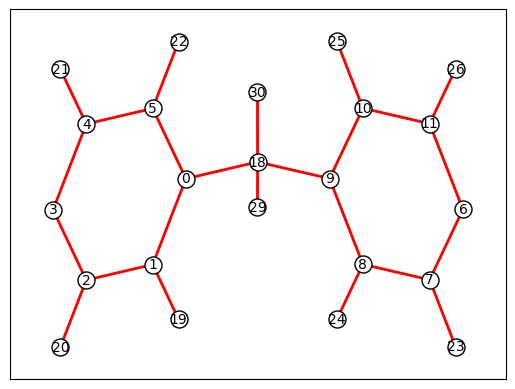

In [8]:
#molecule1 = vlx.Molecule.read_xyz_file('CoTCPP.xyz')
#linker_topic = 4
#molecule1 = vlx.Molecule.read_xyz_file('aa.xyz')
#linker_topic = 3
molecule1 = vlx.Molecule.read_xyz_file('diC2ph.xyz')
linker_topic = 2
molecule1.show(atom_indices=True)

process_linker_molecule(molecule1,linker_topic)



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

center is two points
ditopic linker: center are two points
find connected X in edge:   3
find connected X in edge:   6


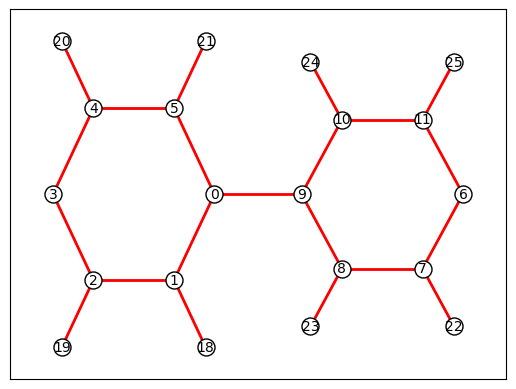

In [9]:
#molecule1 = vlx.Molecule.read_xyz_file('CoTCPP.xyz')
#linker_topic = 4
#molecule1 = vlx.Molecule.read_xyz_file('bb.xyz')
#linker_topic = 3
molecule2 = vlx.Molecule.read_xyz_file('diph.xyz')
linker_topic = 2
molecule2.show(atom_indices=True)

process_linker_molecule(molecule2,linker_topic)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

center is a cycle
tritopic/tetratopic/multitopic: center is a cycle
find connected X in edge frag 0 3 32
find connected X in edge frag 9 6 28
find connected X in edge frag 18 21 30


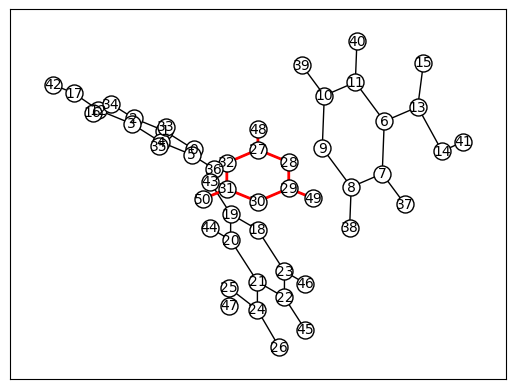

In [10]:
#molecule1 = vlx.Molecule.read_xyz_file('CoTCPP.xyz')
#linker_topic = 4
molecule3 = vlx.Molecule.read_xyz_file('bb.xyz')
linker_topic = 3

molecule3.show(atom_indices=True)

process_linker_molecule(molecule3,linker_topic)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

center is a cycle
tritopic/tetratopic/multitopic: center is a cycle
find connected X in edge frag 33 30 20
find connected X in edge frag 39 36 23
find connected X in edge frag 45 42 22
find connected X in edge frag 27 24 21


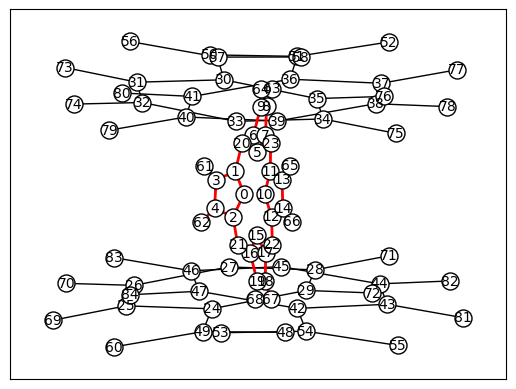

In [11]:
molecule4 = vlx.Molecule.read_xyz_file('CoTCPP.xyz')
linker_topic = 4

molecule4.show(atom_indices=True)

process_linker_molecule(molecule4,linker_topic)